In [1]:
import torch

In [2]:
# Dummy data, points (x, y) that are aproximatelly on a circle
num_points = 10
angles = torch.linspace(torch.pi, (torch.pi / 2), num_points)
radius = 1.0
x = radius * torch.cos(angles) + torch.randn(num_points) * 0.1
y = radius * torch.sin(angles) + torch.randn(num_points) * 0.1

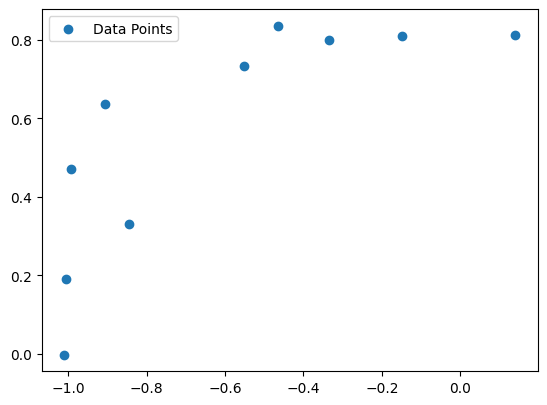

In [3]:
# Plot the generated points 
import matplotlib.pyplot as plt


plt.scatter(x.detach().numpy(), y.detach().numpy(), label="Data Points")
plt.gca().set_aspect("equal", adjustable="box")
plt.legend()
plt.show()

In [4]:
class CircleApproximator(torch.nn.Module):
    def __init__(self):
        super(CircleApproximator, self).__init__()
        # Three scalar parameters: center_x, center_y, radius
        self.center_x = torch.nn.Parameter(torch.tensor(0.0))
        self.center_y = torch.nn.Parameter(torch.tensor(0.0))
        self.radius = torch.nn.Parameter(torch.tensor(1.0))

    def forward(self, x):
        # Return the three parameters for each input point
        batch_size = x.shape[0]
        return torch.stack([
            self.center_x.expand(batch_size),
            self.center_y.expand(batch_size),
            self.radius.expand(batch_size)
        ], dim=1)

def loss_fn(output, data_points):
    # output contains [center_x, center_y, radius] for each point
    # data_points contains [x, y] coordinates of actual data points
    
    # Extract predicted circle parameters
    pred_center_x = output[:, 0]
    pred_center_y = output[:, 1] 
    pred_radius = output[:, 2]
    
    # Extract actual data point coordinates
    data_x = data_points[:, 0]
    data_y = data_points[:, 1]
    
    # Compute distance from each data point to predicted circle center
    dist_to_center = torch.sqrt((data_x - pred_center_x) ** 2 + (data_y - pred_center_y) ** 2)
    
    # Loss is the difference between actual distance and predicted radius
    loss = torch.mean((dist_to_center - pred_radius) ** 2)
    return loss

In [24]:
model = CircleApproximator()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [25]:
# Stack x and y coordinates to create input tensor of shape (num_points, 2)
input_tensor = torch.stack([x, y], dim=1)

lowest_loss = float('inf')
iterations_without_improvement = 0

for i in range(100):
    output = model(input_tensor)
    # Use the actual data points as targets for the loss function
    loss = loss_fn(output, input_tensor)

    if (loss >= lowest_loss):
        iterations_without_improvement += 1
    if (iterations_without_improvement > 5):
        print(f"Iteration {i}: Loss = {loss.item():.6f}")
        print("No improvement for 5 iterations, stopping")
        break

    if (loss < lowest_loss): 
        lowest_loss = loss    

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 10 == 0:  # Print every 10 iterations to reduce output
        print(f"Iteration {i}: Loss = {loss.item():.6f}")
        print(f"  Center: ({model.center_x.item():.3f}, {model.center_y.item():.3f}), Radius: {model.radius.item():.3f}")

Iteration 0: Loss = 0.011769
  Center: (-0.010, -0.010), Radius: 0.990
Iteration 10: Loss = 0.004717
  Center: (-0.103, -0.081), Radius: 0.939
Iteration 19: Loss = 0.004569
No improvement for 5 iterations, stopping


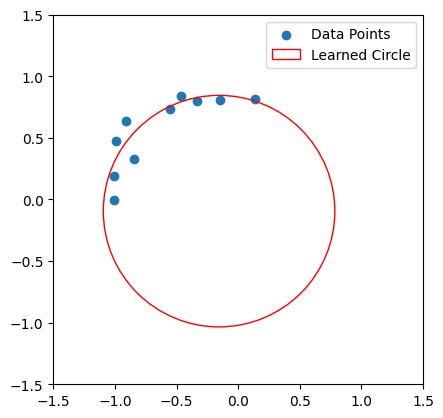

In [26]:
import matplotlib.pyplot as plt

model_out = model(input_tensor)

# Draw the points and the learned circle
plt.scatter(x.numpy(), y.numpy(), label='Data Points')
circle = plt.Circle((model_out[0, 0].item(), model_out[0, 1].item()), model_out[0, 2].item(), color='r', fill=False, label='Learned Circle')
plt.gca().add_artist(circle)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()